# Assignment 3 - Multi-class regression
> **FULL MARKS = 25 * 4 = 100**

In the previous assignments, we investigated Binary classification. For this assignment, we are investigating Multi-class regression. Follow the instructions, you will need to fill the blanks to make it functional.

> **Note**

This assignment is adapted from the coursera online machine learning course. You can refer it here: https://www.coursera.org/learn/machine-learning

In [171]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs4347' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'assignments/cs4347/'
FOLDERNAME = 'INTROtoMAC/Assignment1/cs4347'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs4347/datasets/
!bash assign3_dataset.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs4347/datasets
--2020-11-03 00:44:14--  https://raw.githubusercontent.com/dibgerge/ml-coursera-python-assignments/master/Exercise3/Data/ex3data1.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7511764 (7.2M) [application/octet-stream]
Saving to: ‘data.mat’

data.mat            100%[===================>]   7.16M  44.9MB/s    in 0.2s    

2020-11-03 00:44:14 (44.9 MB/s) - ‘data.mat’ saved [7511764/7511764]

/content


In [172]:
import numpy as np
import matplotlib.pyplot as plt


Load data
________
This dataset contain digit images of 0-9, therefore there are 10 classes.

In [173]:
from cs4347.assignment_datasets import assign3

X, y = assign3()

# print how many classes of this traning set
print(np.unique(y))
X.shape, y.shape

Visualizing the data
_______________

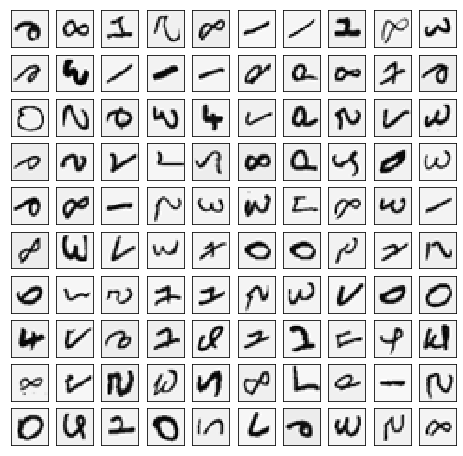

In [174]:
def plot_100_image(X):
  """ 
  Random plot 100 sample images
  """

  # generate 100 random numbers
  sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
  sample_images = X[sample_idx, :]
  
  fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

  for row in range(10):
      for column in range(10):
          ax_array[row, column].matshow(sample_images[10 * row + column].reshape((20, 20)),
                                  cmap='gray_r')
  plt.xticks([])
  plt.yticks([])        
  plt.show()

plot_100_image(X)

Vectorizing the cost function
___________

In [175]:
# define sigmoid function
# same as the previous assignment
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [176]:
# cost function with regularization
def regularized_cost(theta, X, y, l):
    """
    don't penalize theta_0
    args:
      X: feature matrix, (m, n+1)
      y: target vector, (m, )
      l: lambda constant for regularization
    """
    #########################################################################
    # TODO:                                                                 #
    # 1. implement the cross-entropy Loss function                          #
    # 2. Average the cost over the dataset size                             #
    # Hint: Use @ for matrix multiplication                                 #
    #########################################################################
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    fir = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    sec = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (1/2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2))
    j = np.sum(fir - sec) / (len(X)) + reg
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    # return the cost
    return j

Vectorizing the gradient
________________________

In [177]:
# gradient function with regularization
def regularized_gradient(theta, X, y, l):
    """
    don't penalize theta_0
    args:
      l: lambda constant
    return:
      a vector of gradient
    """
    #########################################################################
    # TODO:                                                                 #
    # 1. implement the cross-entropy Loss function                          #
    # 2. Average the grad over the dataset size                             #
    # Hint: Use @ for matrix multiplication                                 #
    #########################################################################
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((1 / len(X)) * theta)
    
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    grad = np.array(grad).ravel()
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    # return the gradients
    return grad

One-vs-all Classification
_____________________

This is the most common strategy for the Multi-class classification/regression. For each classifier, the class is fitted against all the other classes.
For more reading: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [178]:
from scipy.optimize import minimize

def one_vs_all(X, y, l, K):
    """generalized logistic regression
    args:
      X: feature matrix, (m, n+1) # with incercept x0=1
      y: target vector, (m, )
      l: lambda constant for regularization
      K: numbel of labels
    return: trained parameters
    """
    all_theta = np.zeros((K, X.shape[1]))  # (10, 401)
    
    for i in range(1, K+1):
        #########################################################################
        # TODO:                                                                 #
        # 1. Vectorizing the ground-truth label to one-hot code                 #
        # e.g., if y = 3, the one-hot should be 0010000000                      #
        # 2. use minimize method from scipy.optimize                            #
        # e.g.,                                                                 #
        # https://docs.scipy.org/doc/scipy/reference/optimize.minimize-tnc.html #
        # Hint: Use @ for matrix multiplication                                 #
        #########################################################################
        rows = X.shape[0]
        params = X.shape[1]
        theta = np.zeros(params)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i,(rows,1))

        fmin = minimize(fun=regularized_cost, x0=theta, args=(X,y_i,K), method='TNC', jac=regularized_gradient)
        all_theta[i-1,:] = fmin.x

        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################
                   
    return all_theta

Prediction
_____________________


In [184]:
def predict_all(X, all_theta):
    #########################################################################
    # TODO:                                                                 #
    # 1. compute the class probability for each class on each instance      #
    # 2. create array of the index with the maximum probability             #
    # 3. returns the indices of the maximum values along an axis            #
    # Hint: Use np.argmax                                                   #
    #########################################################################
    p = []
    for arr in all_theta:
      p.append(X@arr)
    h_argmax = np.argmax(np.array(p),axis=0)
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

Test accuracy
_____________

In [180]:
raw_X, raw_y = assign3()
X = np.insert(raw_X, 0, 1, axis=1) # (5000, 401)
y = raw_y.flatten()  

all_theta = one_vs_all(X, y, 1, 10)
all_theta 

array([[-3.70247931e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -2.24803602e-10,  2.31962907e-11,  0.00000000e+00],
       [-8.96250716e-05,  0.00000000e+00,  0.00000000e+00, ...,
         7.26120810e-09, -6.19965284e-10,  0.00000000e+00],
       [-8.39553387e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -7.61695633e-10,  4.64917656e-11,  0.00000000e+00],
       ...,
       [-7.00832439e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -6.92009029e-10,  4.29241494e-11,  0.00000000e+00],
       [-7.65187941e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -8.09503274e-10,  5.31058721e-11,  0.00000000e+00],
       [-6.63412747e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -3.49766172e-09,  1.13668635e-10,  0.00000000e+00]])

In [185]:
y_pred = predict_all(X, all_theta)
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 74.6%
